<a href="https://colab.research.google.com/github/hduongck/AI-ML-Learning/blob/master/2019%20Fastai%20Deep%20Learning/2019_Deep_Learning_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This time part 2 is very different from the 2018 version. The course name is “Deep Learning from the Foundations”. **We will learn to implement a lot of things that are inside Fastai and PyTorch. Basically, we will learn things that we could use to build our own deep learning libraries**. Along the way, we will learn to implement papers which is an important skill to master when making state of the art models.

Purpose of this part is opposite to part 1. This time we don’t learn practical things that we will use for something but more like how to learn these things by ourselves after this course ends. This is important nowadays because this area is moving so fast.

**On the last two lessons, we will learn about Swift**. The reason we will learn another programming language that doesn’t have proper deep learning libraries is that the person (Chris Lattner) who created the most used compiling tools is now focusing on deep learning and Swift (which he also created). Current deep learning libraries are more or less developed by a bunch of deep learning nerds that doesn’t necessarily have as much knowledge about programming as compiler guys. This means that Swift is much better for DL than Python because it is faster and more optimized.


```
“There is no way I will be missing out that boat.” — Jeremy
```

Another language that has also potential is Julia. It is not as potential as Swift but you shouldn’t put all eggs into one basket. Learning Julia at a high level doesn’t take much time but it can pay off well in the future.

**Next, we will start to implement Fastai from scratch**. To make this interesting Jeremy made some rules about what tools/libraries we can use.
- Python
- Python standard libraries
- Non-data science modules (like requests library for http)
- PyTorch — ONLY for creating arrays, random number generation, and indexing into arrays
- Fastai.datasets (datasets like MNIST)
- Matplotlib (for plots)

After we have implemented some part of Fastai or PyTorch we will use it normally to make the code easier to read.

**Creating a great model consists three steps:**
- Overfit (Validation loss starts to increase)
- Reduce overfitting
- Visualize the outputs

Creating an model that overfit isn’t that complicated. To reduce overfitting you need to do the following things (in order):
- More data
- Data augmentation
- Generalizable architectures
- Regularization
- Reduce architecture complexity

![alt text](https://github.com/hduongck/AI-ML-Learning/blob/master/Pic/Annotation%202019-06-30%20135010.png?raw=true)

We learned these things in the part 1.

**Papers often contain a lot of math that might be hard to understand right away**. It is important to learn Greek letters. The person who wrote the paper doesn’t necessarily have the talent to explain things simply. That is why you also should read blog posts or watch videos about the paper you are reading.

![alt text](https://github.com/hduongck/AI-ML-Learning/blob/master/Pic/Annotation%202019-06-30%20134828.png?raw=true)

If there is mathematical symbols that you doesn’t understand: 

https://en.wikipedia.org/wiki/List_of_mathematical_symbols http://detexify.kirelabs.org/classify.html



# Steps to a basic CNN models

![alt text](https://github.com/hduongck/AI-ML-Learning/blob/master/Pic/cnn%20workflow.png?raw=true)



## Start with matmul

Matrix multiplication from foundations

The foundations we'll assume throughout this course are:

- Python
- Python modules (non-DL)
- pytorch indexable tensor, and tensor creation (including RNGs - random number generators)
- fastai.datasets

In [0]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle,gzip,math,torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [0]:
path = datasets.download_data(MNIST_URL, ext='.gz'); path

PosixPath('/root/.fastai/data/mnist.pkl.gz')

In [0]:
with gzip.open(path,'rb') as f:
    ((x_train,y_train),(x_valid,y_valid),_)=pickle.load(f,encoding='latin-1')
    

In [0]:
x_train,y_train,x_valid,y_valid=map(tensor,(x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train,x_train.shape,y_train,y_train.shape,y_train.min(),y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [0]:
mpl.rcParams['image.cmap']='gray'

In [0]:
img = x_train[0]

In [0]:
img.view(28,28).type()

'torch.FloatTensor'

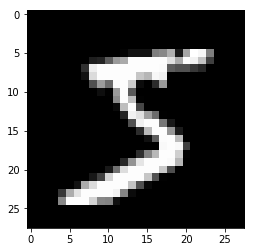

In [0]:
plt.imshow(img.view(28,28))

initial python model


In [0]:
weights = torch.rand(784,10)

784 is input and 10 is output of model

In [0]:
bias = torch.zeros(10)

We make a matrix multiplication

In [0]:
def matmul(a,b):
    ar,ac = a.shape #n_rows * n_cols
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar,bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): # or br
                c[i,j] += a[i,k] * b[k,j]
    return c
    

do a small example

In [0]:
m1 = x_valid[:5]
m2 = weights

In [0]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [0]:
%time t1 = matmul(m1,m2)

CPU times: user 901 ms, sys: 10 µs, total: 901 ms
Wall time: 919 ms


In [0]:
t1.shape

torch.Size([5, 10])

In [0]:
len(x_train)

50000

when our Mnist dataset has 50000 rows, it will take about 50000 seconds to do a single matrix multiplication in Python. So imaging doing Mnist for every layer for every pass took about 10 hours. It's not going to work right. We don't really write thing in Python when we say Python is too slow. It 's not just 20% too slow, we mean thousand of times too slow.

let's see if we could speed it up by 50000 times. We can speed it up by starting in the innermost loop 



```
for k in range(ac): # or br
                c[i,j] += a[i,k] * b[k,j]
```

and we make bit faster. The way to make Python faster is to remove Python by passing something that's written in something other than Python like Pytorch operations



###Elementwise operations

Operators (+,-,*,/,>,<,==) are usually element-wise.

Examples of element-wise operations:

In [0]:
a = tensor([10.,6,-4])
b = tensor([2.,8,7])
a,b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [0]:
a + b

tensor([12., 14.,  3.])

another example: using less than. what percentage of a less than the corresponding item of B.

In [0]:
(a<b).float().mean()

tensor(0.6667)

we can do element-wise operations not just on rank-1 tensor, also on rank-2 tensor known as matrix. Below is rank-2 tensor called m

In [0]:
m = tensor([[1.,2,3],[4,5,6],[7,8,9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Now we learn how to calculate the formular name Frobenius norm:

$\|A\|_{F}=\left(\sum_{i, j=1}^{n}\left|a_{i j}\right|^{2}\right)^{1 / 2}$

Now we can start try to translate some equations into code to help us understand these equations

In [0]:
(m*m).sum().sqrt()

tensor(16.8819)

Now we use this to replace the 3rd loop in matmul def

```
for k in range(ac): # or br
                c[i,j] += a[i,k] * b[k,j]
```

In [0]:
def matmul(a,b):
    ar,ac = a.shape #n_rows * n_cols
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar,bc)
    for i in range(ar):
        for j in range(bc):
            # any trailing ",:" can be removed
            c[i,j] = (a[i,:]*b[:,j]).sum()
    return c
    
    

In [0]:
%timeit -n 10 _=matmul(m1,m2)

10 loops, best of 3: 1.59 ms per loop


In [0]:
890.1/5

178.02

it's 178 times faster. `c[i,j] = (a[i,:]*b[:,j]).sum()`this is not really Python thing, this line will call C code for us and that make 178 times faster.

Now we will continue to remove the second loop in matmul def by using a technique called Broadcasting


```
for j in range(bc):
            # any trailing ",:" can be removed
            c[i,j] = (a[i,:]*b[:,j]).sum()
```





###Broadcasting

The term broadcasting describes how arrays with different shapes are treated during arithmetic operations. The term broadcasting was first used by Numpy.

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):


```
The term broadcasting describes how numpy treats arrays with 
different shapes during arithmetic operations. Subject to certain 
constraints, the smaller array is “broadcast” across the larger 
array so that they have compatible shapes. Broadcasting provides a 
means of vectorizing array operations so that looping occurs in C
instead of Python. It does this without making needless copies of 
data and usually leads to efficient algorithm implementations.
```



In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

This section was adapted from [Chapter 4 ](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/4.%20Compressed%20Sensing%20of%20CT%20Scans%20with%20Robust%20Regression.ipynb#4.-Compressed-Sensing-of-CT-Scans-with-Robust-Regression)of the fast.ai [Computational Linear Algebra course](https://github.com/fastai/numerical-linear-algebra).

Broadcasting is the most powerful tool for writing code in Python that runs at C speed or infact with Pytorch if you put it in GPU then it's going to run at CUDA speed. It allows us to get rid of nearly all of our loops

**Broadcasting with a scalar**

In [0]:
a

tensor([10.,  6., -4.])

In [0]:
a > 0

tensor([1, 1, 0], dtype=torch.uint8)

the value 0 is broadcast three times. it does element-wise comparision. You are broadcasting a scaler to a tensor.

How are we able to do a > 0? 0 is being broadcast to have the same dimensions as a.

For instance you can normalize our dataset by subtracting the mean (a scalar) from the entire data set (a matrix) and dividing by the standard deviation (another scalar), using broadcasting.

Other examples of broadcasting with a scalar:

In [0]:
a +1

tensor([11.,  7., -3.])

In [0]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [0]:
2*m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

this is the simplest kind of broadcasting. Anytime you are doing that, you re' not operating at Python speed , you're operating at C or CUDA speed.

We can also **broadcast a vector to a matrix**



In [0]:
c = tensor([10.,20,30]); c


tensor([10., 20., 30.])

In [0]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [0]:
m.shape,c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [0]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

again all there was loop behind the m+c but it is a C loop not Python loop. 

In [0]:
c + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

We don't really copy the rows, but it looks as if we did. In fact, the rows are given a stride of 0.

In [0]:
t = c.expand_as(m)


`c.expand_as (m)` shows us what C looks like when broadcast to **m**. 

In [0]:
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

then m + t is the same as c + m

In [0]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

so it's actually if it is creating this bigger rank-2 tensor. 

You may worry t shape look very memory intensive if turning all our rows into a big matrices but fear not. Because you can look inside the actually memory use by pytorch

In [0]:
t.storage()

 10.0
 20.0
 30.0
[torch.FloatStorage of size 3]

t matrices above 3 copies of row but actually t.storage() show that the system only store one copy of that data.

In [0]:
t.stride(),t.shape

((0, 1), torch.Size([3, 3]))

t.shape tell us it is 3x3 matrix and t.stride() tells us that it knows when it 's going from column to column it should take 1 step through the storage .But when it goes from row to row it should take zero step so that how come it repeat 10 20 30 10 20 30 10 20 30 . This is very powerful thing that appear in pretty much linear algebra library . Conclusion : Broadcasting functionality gives us C like speed but with no addtional memory overhead.

**What if we want to take column instead of the row**. We can have tensor of shape (3,1) from a rank-1 tensor by using the **unsqueeze(1)**. Unsqueeze(1) add addtional dimension of size one to where we ask for.

In [0]:
c

tensor([10., 20., 30.])

In [0]:
c.unsqueeze(0)

tensor([[10., 20., 30.]])

In [0]:
c.unsqueeze(1)

tensor([[10.],
        [20.],
        [30.]])

In [0]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

You can index with the special value [None] or use unsqueeze() to convert a 1-dimensional array into a 2-dimensional array (although one of those dimensions has value 1).

c[None , :] means squeeze a new axis in here.

In [0]:
c.shape,c.unsqueeze(0).shape,c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

In [0]:
c.shape,c[None,:].shape,c[:,None].shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

You can always skip trailling ':'s. And '...' means 'all preceding dimensions'

In [0]:
c[None].shape,c[...,None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

c[...,None] -> the ... are used in high rank tensor, especial it would vary , you don't know how big it's going to be ahead

In [0]:
c[:,None].expand_as(m)

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

this broadcast along the columns instead of rows. When I use c[:,None] to add to m, we are broadcasting the columns instead of row. 

In [0]:
m + c[:,None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

Now we can use this to get rig of the loop


```
for j in range(bc):
            # any trailing ",:" can be removed
            c[i,j] = (a[i,:]*b[:,j]).sum()
```

Now so it is:

In [0]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar,bc)
    for i in range(ar):
        for j in range(bc):
            
            c[i:] = (a[i ].unsqueeze(-1)*b).sum(dim=0)
    

as a[i ] is rank-1 tensor. Now we turn it into rank-2 tensor by adding unsqueeze(-1). -1 always means the last dimension.

- `a[i].unsqueeze(1)` can be rewrite into `a[i,None]` 
- b is also rank-2 tensor

Finally, it would get broadcast over this which return a rank-2 tensor. 

- we then want to sum it over rows


In [0]:
%timeit -n 10 _=matmul(m1,m2)

10 loops, best of 3: 3.22 ms per loop


In [0]:
885000/277

3194.945848375451

**There are some broadcasting rules**

In [0]:
c[None,:]

tensor([[10., 20., 30.]])

In [0]:
c[None,:].shape

torch.Size([1, 3])

In [0]:
c[:,None]

tensor([[10.],
        [20.],
        [30.]])

In [0]:
c[:,None].shape

torch.Size([3, 1])

In [0]:
c[None,:] * c[:,None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

In [0]:
c[None,:] > c[:,None]

tensor([[0, 1, 1],
        [0, 0, 1],
        [0, 0, 0]], dtype=torch.uint8)

When operating on two arrays/tensors, Numpy/PyTorch compares their shapes element-wise. It starts with the trailing dimensions, and works its way forward. Two dimensions are compatible when

    - they are equal, or
    - one of them is 1, in which case that dimension is broadcasted to make it the same size
    
Arrays do not need to have the same number of dimensions. For example, if you have a 256*256*3 array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:


```
mage  (3d array): 256 x 256 x 3
Scale  (1d array):             3
Result (3d array): 256 x 256 x 3
```

The numpy documentation includes several examples of what dimensions can and can not be broadcast together.

###Einstein summation

Einstein summation (einsum) is a compact representation for combining products and sums in a general way. From the numpy docs:

"The subscripts string is a comma-separated list of subscript labels, where each label refers to a dimension of the corresponding operand. Whenever a label is repeated it is summed, so **np.einsum('i,i', a, b)** is equivalent to np.inner(a,b). If a label appears only once, it is not summed, so **np.einsum('i', a)** produces a view of a with no changes."

In [0]:
# c[i,j] += a[i,k] * b[k,j]
# ik,kj -> ij
# c[i,j] = (a[i,:] * b[:,j]).sum()
def matmul(a,b) : return torch.einsum('ik,kj->ij',a,b)

In [0]:
%timeit -n 10 _=matmul(m1,m2)

The slowest run took 46.32 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 52.2 µs per loop


In [0]:
885000/55

16090.90909090909

###Pytorch operation

Next thing to show is pytorch operation called matmul. And matmul boost the speed to 50000 times faster than python. WHY? 

- When you do a matrix multiplication of something that's like 50000 x 768 x 768 x 10. This things are going to fit in like cache in your CPU. So if you do the kind of standard thing of going down all the rows and across all the columns. By the time you cut to the end and you go back to exactly the same column again and it forgot contents, it has to go back to RAM and pull it in again right. So if you re smart what you do is you break your matrix up into litlle smaller matrices and you do a little bit at a time. That way everything is kind of in cache and it goes super fast now. Normally to do that you have to write kind of assembly language code, particulary if you want to kind of get it all runnning in your vector precessor. And that's how you get these 18 microseconds. Currently to get a fast matrix mutiply, things like pytorch that they don't even write it themselves, they basically push that off to something called a blas. Blas is a basic linear algebra subprograms library where companies like Intel, AMD, NVIDIA draft these things for you. For example. cuBlas of Nvidia

In [0]:
%timeit -n 10 t2 = m1.matmul(m2)

The slowest run took 66.26 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 10.9 µs per loop


the matmul operation is written in one thing that to be turned that pre-existing blas

In [0]:
t2 = m1@m2

@ is annotation of matmul so they are exact same code with same speed.

## Relu/init -> FC forward -> BC forward

Firstly we create a nomalization function that takes our tensor and subtracts the mean and divides by the standard deviation function

In [0]:
def normalize(x, m, s): return (x-m)/s

Then let's grab the mean and the std

In [0]:
train_mean,train_std = x_train.mean(),x_train.std()
train_mean,train_std

(tensor(0.1304), tensor(0.3073))

I notice that they are not 0 and 1. Why? Currently Jeremy states that we want they are 0 and 1. will find out later

Before that we will normalize x_train and x_valid. And to make sure x_train and x_valid have same scale by normalizing in the same way.

In [0]:
x_train = normalize(x_train,train_mean,train_std)
# NB : Use training, not validation mean for validation set
x_valid = normalize(x_valid,train_mean,train_std)

In [0]:
train_mean,train_std = x_train.mean(),x_train.std()
train_mean,train_std

(tensor(0.0001), tensor(1.))

Now train_mean is close 0 and train_std is close to 1. To check these are true, we create a function called test_near_zero

In [0]:
def test_near_zero(a,tol=1e-3): assert a.abs()<tol, f'Near zero:{a}'

In [0]:
test_near_zero(x_train.mean())
test_near_zero(1-x_train.std())

In [0]:
n,m = x_train.shape
c = y_train.max()+1
n,m,c

(50000, 784, tensor(10))

n : number of rows

m : number of columns

c: number of outputs

### Create a model

- one hidden layer
- output with 10 activations. But we don't use cross entropy to get 10 activation. We will use mean squared error which means we going to have one activation. We will fix this later as we try to simplify things for now

**Basic architecture**



In [0]:
# num of hidden
nh =50

for two layers, we re going to need two weight matrices and two bias vectors

- w1 : randomize a matrix with m: columns,768 by nh: number of hidden,50
- w2 : randomize a matrix with nh by 1 output


In [0]:
# simplified kaiming init / he init
w1 = torch.randn(m,nh)/math.sqrt(m)
b1 = torch.zeros(nh)
w2 = torch.randn(nh,1)/math.sqrt(nh)
b2 = torch.zeros(1)



Note that we have input in the first layer with mean 0 and std 1, we also want the input in the second layer with mean 0 and std 1 well. How we are going to do that? Because if just grab some normal random number and we define a linear function called lin. We make the t, output of activattion with X_valid, weight 1 and bias 1. We have t.mean is 1 and t.std is 27 which are very terrible

![alt text](https://github.com/hduongck/AI-ML-Learning/blob/master/Pic/model%20architecture.png?raw=true)

But instead if we initialize the weights by adding dividing by math.sqrt() then the result is actually good

In [0]:
test_near_zero(w1.mean())
test_near_zero(w1.std()-1/math.sqrt(m))

In [0]:
# This should be ~ (0,1) (mean,std)...
x_train.mean(),x_train.std()

(tensor(0.0001), tensor(1.))

In [0]:
def lin(x,w,b): return x@w + b

In [0]:
t = lin(x_valid,w1,b1)

In [0]:
t.mean(),t.std()

(tensor(-0.0356), tensor(0.9623))

This method called Kaiming initialization which after we randomize then we add dividing by math.sqrt() which would give us mean of 0 and standard deviation of 1.

**def lin(x,w,b): return x@w + b** is not how our first layer is defined. It is defined by ReLU on it


```
t = relu(lin(x_valid, w1, b1))
```

Now we define ReLU


In [0]:
def relu(x) : return x.clamp_min(0.) # replace any negative with 0

In [0]:
t = relu(lin(x_valid,w1,b1))

In [0]:
t.mean(),t.std()

(tensor(0.3627), tensor(0.5508))

Unfortunately, that does not give mean of 0 or std of 1. Why not? explained in the pic below

![alt text](https://github.com/hduongck/AI-ML-Learning/blob/master/Pic/Annotation%202019-07-01%20145636.png?raw=true)

There is a fantastic insights [paper](https://arxiv.org/abs/1502.01852) look into this problem.

In the paper, it recommend :

From pytorch docs: a: the negative slope of the rectifier used after this layer (0 for ReLU by default)

$$\text{std} = \sqrt{\frac{2}{(1 + a^2) \times \text{fan_in}}}$$

This was introduced in the paper that described the Imagenet-winning approach from He et al: Delving Deep into Rectifiers, which was also the first paper that claimed "super-human performance" on Imagenet (and, most importantly, it introduced resnets!)



In [0]:
# kaiming init / he init for relu
w1 = torch.randn(m,nh)*math.sqrt(2/m)

In [0]:
w1.mean(),w1.std()

(tensor(-0.0001), tensor(0.0503))

In [0]:
t = relu(lin(x_valid,w1,b1))
t.mean(),t.std()

(tensor(0.5573), tensor(0.8265))

The std result is much closer to 1 although not perfect. But it still does not give us very nice mean as we saw we deleted everything belwo 0. So naturally our mean is 0.5 not 0. There is solution that Jeremy recommend by modyfing the relu() function



```
def relu(x): return x.clamp_min(0.) - 0.5
```

This would give us nice mean.

In [0]:
from torch.nn import init

Now we replace 

```
w1 = torch.randn(m,nh)*math.sqrt(2/m)
```
by 



```
init.kaiming_normal(w1,mode='fan_out')
```




In [0]:
w1 = torch.randn(m,nh)
init.kaiming_normal_(w1,mode='fan_out')
t = relu(lin(x_valid,w1,b1))

let's check if we have same result

In [0]:
t.mean(),t.std()

(tensor(0.5566), tensor(0.8456))

Notice in init.kaiming_normal_ we add something extra with mode ='fan_out'. This means it is used for backward pass to keep the unit variance. Because our weight w1's shape is 784 by 50

In [0]:
w1.shape

torch.Size([784, 50])

In [0]:
import torch.nn

In [0]:
torch.nn.Linear(m,nh).weight.shape

torch.Size([50, 784])

In [0]:
torch.nn.Linear.forward??

In [0]:
torch.nn.functional.linear??

In [0]:
torch.nn.Conv2d??

In [0]:
torch.nn.modules.conv._ConvNd.reset_parameters??

get back to model. 

In [0]:
def relu(x): return x.clamp_min(0.) - 0.5

In [0]:
w1 = torch.randn(m,nh)*math.sqrt(2./m)
t1 = relu(lin(x_valid,w1,b1))
t1.mean(),t1.std()

(tensor(0.0753), tensor(0.8512))

Now I have mean of 0. It also somehow help my std closer to 1. 

So far, we have relu, linear, ... , we can now do a forward pass

In [0]:
def model(xb):
    l1 = lin(xb,w1,b1)
    l2 = relu(l1)
    l3 = lin(l2,w2,b2)
    return l3

In [0]:
%timeit -n 10 _= model(x_valid)

10 loops, best of 3: 20.9 ms per loop


Add an assert to make sure this shape seems sensible 

In [0]:
assert model(x_valid).shape ==torch.Size([x_valid.shape[0],1])

The next thing we need for a forward pass is a loss function as I said we use MSE to simply thing

### Loss function: MSE


In [0]:
model(x_valid).shape

torch.Size([10000, 1])

Our model return something of size 10000 by 1 but the MSE expect a single vector of size 10000. So we want to get rig of unit axis. In Pytorch we use squeeze

We need squeeze() to get rid of that trailing (,1), in order to use mse. (Of course, mse is not a suitable loss function for multi-class classification; we'll use a better loss function soon. We'll use mse for now to keep things simple.)

In [0]:
def mse(output,targ): return (output.squeeze(-1) - targ).pow(2).mean()

in MSE, we make sure the value are float

In [0]:
y_train,y_valid = y_train.float(),y_valid.float()

In [0]:
preds = model(x_train)

In [0]:
preds.shape

torch.Size([50000, 1])

we calculate mse

In [0]:
mse(preds,y_train)

tensor(27.4439)

Now we have done a forward pass. A forward pass is actually useless , what we need is a backward pass because that thing tells us how to update our parameters. So now we need gradients.

### Gradient and backward pass

In [0]:
No